In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from tools import compute_PCA, compute_TSNE, load_data

In [2]:
X, y, p = load_data(
    [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14], z_score_norm="participant_meanfree"
)
X = X.reshape(X.shape[0], X.shape[1] * X.shape[1])

load: ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P09', 'P10', 'P11', 'P12', 'P13', 'P14']
before: 0.010833320819703356 0.0138765904356241
after global: 3.3453047822980234e-16 1.0
before: 0.014157458413294332 0.019697427174936128
after global: 5.144634718234897e-16 0.9999999999999999
before: 0.009671310470783361 0.01382165546457677
after global: 5.894732537024589e-17 0.9999999999999996
before: 0.014321327169414132 0.02092426207628347
after global: -8.412627794765627e-17 0.9999999999999994
before: 0.008012871473850146 0.008465251726686069
after global: -2.9350674187145196e-16 0.9999999999999999
before: 0.015501076883670332 0.020161922062374903
after global: -2.3778118615833976e-16 0.9999999999999998
before: 0.005785778427333883 0.008299444524589267
after global: -9.745232778682356e-18 1.0
before: 0.0105969642036091 0.012696071282817526
after global: 2.4956514487339933e-16 1.0
before: 0.01125014743993877 0.015176670562493291
after global: -2.5283174943567163e-16 0.9999999999999997

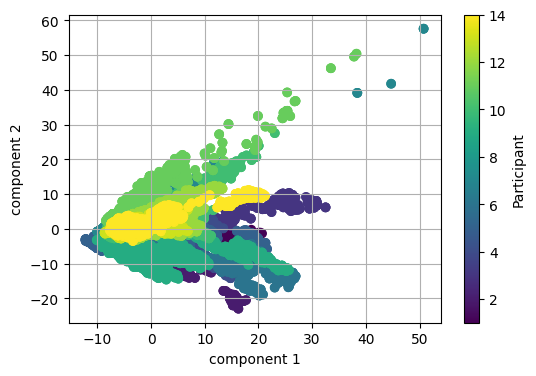

In [3]:
compute_PCA(
    X,
    feature=p,
    feature_label="Participant",
)

In [4]:
X.shape, y.shape

((60572, 256), (60572,))

**3 level classification***

- low torque
- medium torque 
- high torque

In [5]:
def classification(y, levels=3, prints: bool = True):
    if levels == 3:
        lower_bound = np.percentile(y, 33.3)
        upper_bound = np.percentile(y, 66.6)

        categories = list()
        labels = list()

        for value in y:
            if value <= lower_bound:
                categories.append(0)
                labels.append("low")
            elif value <= upper_bound:
                categories.append(1 / 2)
                labels.append("medium")
            else:
                categories.append(1)
                labels.append("high")

        categories = np.array(categories)
        labels = np.array(labels)
        if prints:
            print(
                "low:",
                len(np.where(labels == "low")[0]),
                "medium:",
                len(np.where(labels == "medium")[0]),
                "high:",
                len(np.where(labels == "high")[0]),
            )
    elif levels == 2:
        bound = np.percentile(y, 50.0)

        categories = list()
        labels = list()

        for value in y:
            if value <= bound:
                categories.append(0)
                labels.append("low")
            else:
                categories.append(1)
                labels.append("high")

        categories = np.array(categories)
        labels = np.array(labels)
        if prints:
            print(
                "low:",
                len(np.where(labels == "low")[0]),
                "high:",
                len(np.where(labels == "high")[0]),
            )
    return categories, labels

In [6]:
y_cat, y_lab = classification(y, 3)

low: 20171 medium: 20170 high: 20231


In [7]:
selcts = np.where(y_lab == "low")[0]
print("low range:\t", np.min(y[selcts]), np.max(y[selcts]))
selcts = np.where(y_lab == "medium")[0]
print("medium range:\t", np.min(y[selcts]), np.max(y[selcts]))
selcts = np.where(y_lab == "high")[0]
print("high range:\t", np.min(y[selcts]), np.max(y[selcts]))

low range:	 -4.572675665422792 28.60641623314143
medium range:	 28.60662652205016 49.35496412584323
high range:	 49.35640664113451 125.50900164458406


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_lab, test_size=0.2, random_state=42
)

**SVM Method**

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train SVM model
svm_model = SVC(kernel="rbf")
svm_model.fit(X_train, y_train)

SVC()

SVM Accuracy: 0.82


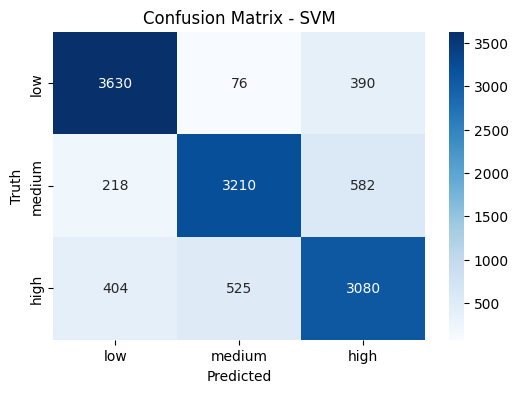

              precision    recall  f1-score   support

         low       0.85      0.89      0.87      4096
      medium       0.84      0.80      0.82      4010
        high       0.76      0.77      0.76      4009

    accuracy                           0.82     12115
   macro avg       0.82      0.82      0.82     12115
weighted avg       0.82      0.82      0.82     12115



In [10]:
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.2f}")
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_svm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["low", "medium", "high"],
    yticklabels=["low", "medium", "high"],
)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title("Confusion Matrix - SVM")
plt.show()

print(classification_report(y_test, y_pred_svm, target_names=["low", "medium", "high"]))

**Random forest**

Random Forest Accuracy: 0.98


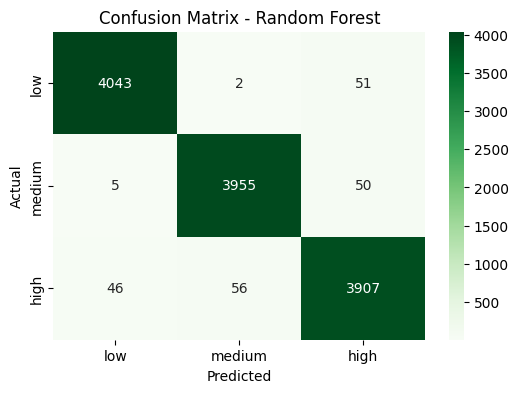

              precision    recall  f1-score   support

         low       0.99      0.99      0.99      4096
      medium       0.99      0.99      0.99      4010
        high       0.97      0.97      0.97      4009

    accuracy                           0.98     12115
   macro avg       0.98      0.98      0.98     12115
weighted avg       0.98      0.98      0.98     12115



In [11]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["low", "medium", "high"],
    yticklabels=["low", "medium", "high"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

print(classification_report(y_test, y_pred_rf, target_names=["low", "medium", "high"]))

### Test with unknown participant

In [12]:
X, y, p = load_data(
    [1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13], z_score_norm="participant_meanfree"
)
X_train = X.reshape(X.shape[0], X.shape[1] * X.shape[1])
_, y_train = classification(y)

X_test, y_test, p_test = load_data([14], z_score_norm="participant_meanfree")
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[1])

# test data of participant
_, y_test = classification(y_test)

load: ['P01', 'P03', 'P04', 'P05', 'P06', 'P07', 'P09', 'P10', 'P11', 'P12', 'P13']
before: 0.010833320819703356 0.0138765904356241
after global: 3.3453047822980234e-16 1.0
before: 0.009671310470783361 0.01382165546457677
after global: 5.894732537024589e-17 0.9999999999999996
before: 0.014321327169414132 0.02092426207628347
after global: -8.412627794765627e-17 0.9999999999999994
before: 0.008012871473850146 0.008465251726686069
after global: -2.9350674187145196e-16 0.9999999999999999
before: 0.015501076883670332 0.020161922062374903
after global: -2.3778118615833976e-16 0.9999999999999998
before: 0.005785778427333883 0.008299444524589267
after global: -9.745232778682356e-18 1.0
before: 0.0105969642036091 0.012696071282817526
after global: 2.4956514487339933e-16 1.0
before: 0.01125014743993877 0.015176670562493291
after global: -2.5283174943567163e-16 0.9999999999999997
before: 0.010497400251044876 0.011441049062675797
after global: -9.633351723722724e-17 0.9999999999999997
before: 0.01

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["low", "medium", "high"],
    yticklabels=["low", "medium", "high"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

print(classification_report(y_test, y_pred_rf, target_names=["low", "medium", "high"]))

### Test with unknown participant - crossvadidation

Train participant: [ 2  3  4  5  6  7  9 10 11 12 13 14]
Test participant: 1
low: 19463 medium: 19463 high: 19522
low: 707 medium: 707 high: 710
SVM Accuracy: 0.35


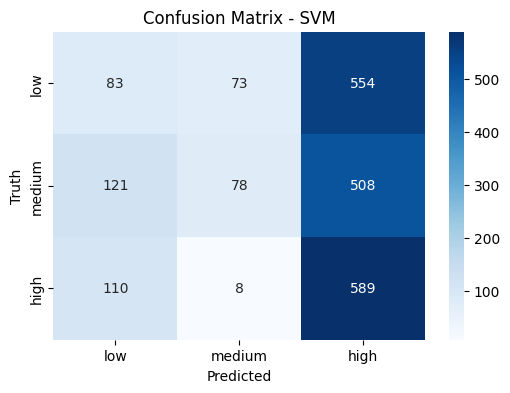

              precision    recall  f1-score   support

         low       0.26      0.12      0.16       710
      medium       0.49      0.11      0.18       707
        high       0.36      0.83      0.50       707

    accuracy                           0.35      2124
   macro avg       0.37      0.35      0.28      2124
weighted avg       0.37      0.35      0.28      2124

Train participant: [ 1  3  4  5  6  7  9 10 11 12 13 14]
Test participant: 2
low: 18839 medium: 18838 high: 18895
low: 1332 medium: 1332 high: 1336
SVM Accuracy: 0.41


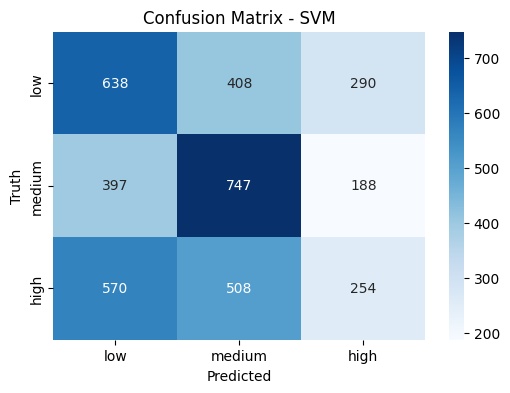

              precision    recall  f1-score   support

         low       0.40      0.48      0.43      1336
      medium       0.45      0.56      0.50      1332
        high       0.35      0.19      0.25      1332

    accuracy                           0.41      4000
   macro avg       0.40      0.41      0.39      4000
weighted avg       0.40      0.41      0.39      4000

Train participant: [ 1  2  4  5  6  7  9 10 11 12 13 14]
Test participant: 3
low: 18643 medium: 18642 high: 18699
low: 1528 medium: 1527 high: 1533
SVM Accuracy: 0.25


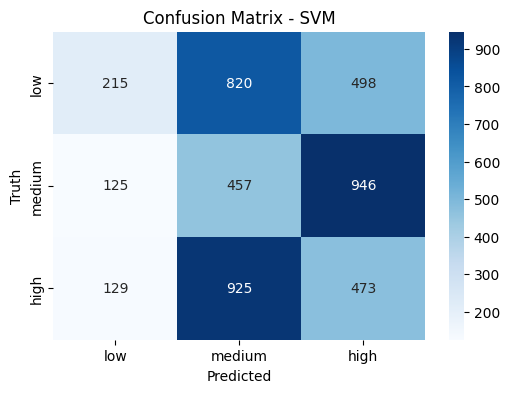

              precision    recall  f1-score   support

         low       0.46      0.14      0.21      1533
      medium       0.21      0.30      0.25      1528
        high       0.25      0.31      0.27      1527

    accuracy                           0.25      4588
   macro avg       0.30      0.25      0.24      4588
weighted avg       0.30      0.25      0.24      4588

Train participant: [ 1  2  3  5  6  7  9 10 11 12 13 14]
Test participant: 4
low: 18654 medium: 18654 high: 18711
low: 1516 medium: 1516 high: 1521
SVM Accuracy: 0.24


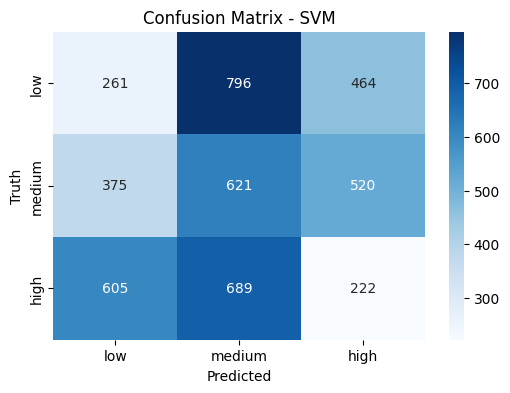

              precision    recall  f1-score   support

         low       0.21      0.17      0.19      1521
      medium       0.29      0.41      0.34      1516
        high       0.18      0.15      0.16      1516

    accuracy                           0.24      4553
   macro avg       0.23      0.24      0.23      4553
weighted avg       0.23      0.24      0.23      4553

Train participant: [ 1  2  3  4  6  7  9 10 11 12 13 14]
Test participant: 5
low: 18452 medium: 18452 high: 18507
low: 1719 medium: 1718 high: 1724
SVM Accuracy: 0.33


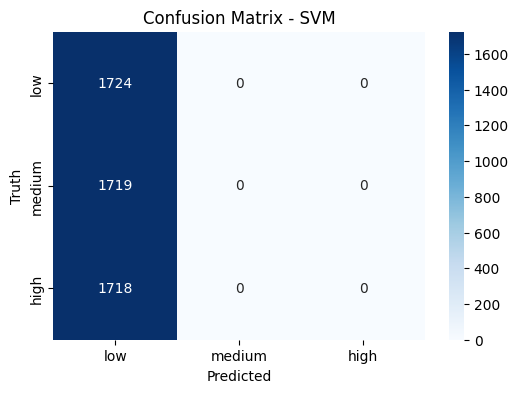

              precision    recall  f1-score   support

         low       0.33      1.00      0.50      1724
      medium       0.00      0.00      0.00      1719
        high       0.00      0.00      0.00      1718

    accuracy                           0.33      5161
   macro avg       0.11      0.33      0.17      5161
weighted avg       0.11      0.33      0.17      5161

Train participant: [ 1  2  3  4  5  7  9 10 11 12 13 14]
Test participant: 6


/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


low: 18378 medium: 18378 high: 18433
low: 1793 medium: 1792 high: 1798
SVM Accuracy: 0.25


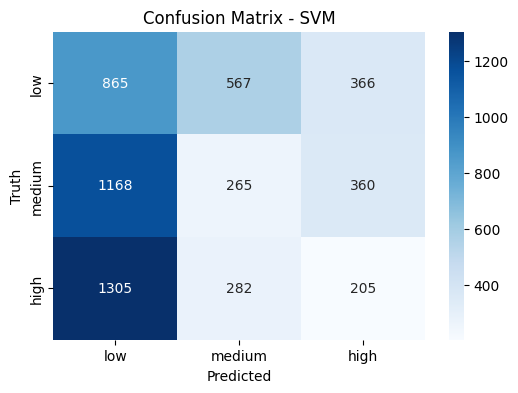

              precision    recall  f1-score   support

         low       0.26      0.48      0.34      1798
      medium       0.24      0.15      0.18      1793
        high       0.22      0.11      0.15      1792

    accuracy                           0.25      5383
   macro avg       0.24      0.25      0.22      5383
weighted avg       0.24      0.25      0.22      5383

Train participant: [ 1  2  3  4  5  6  9 10 11 12 13 14]
Test participant: 7
low: 18759 medium: 18759 high: 18816
low: 1411 medium: 1411 high: 1416
SVM Accuracy: 0.41


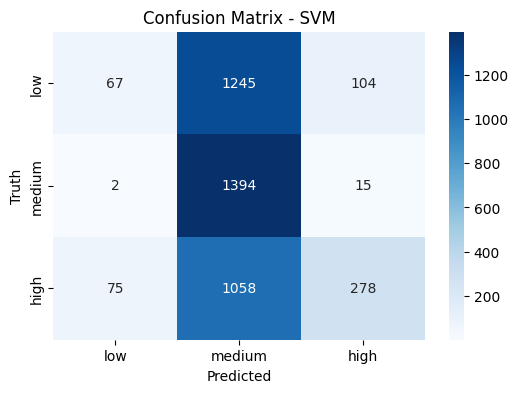

              precision    recall  f1-score   support

         low       0.47      0.05      0.09      1416
      medium       0.38      0.99      0.55      1411
        high       0.70      0.20      0.31      1411

    accuracy                           0.41      4238
   macro avg       0.51      0.41      0.31      4238
weighted avg       0.51      0.41      0.31      4238

Train participant: [ 1  2  3  4  5  6  7 10 11 12 13 14]
Test participant: 8
low: 18440 medium: 18440 high: 18496


/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IndexError: tuple index out of range

In [25]:
load_part_list = np.array([1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14])
for ps in range(1, len(load_part_list) + 1):
    new_arr = np.delete(load_part_list, ps - 1)
    print("Train participant:", new_arr)
    print("Test participant:", ps)

    X, y, p = load_data(new_arr, z_score_norm="participant_meanfree", print_info=False)
    X_train = X.reshape(X.shape[0], X.shape[1] * X.shape[1])
    _, y_train = classification(y)

    X_test, y_test, p_test = load_data(
        [ps], z_score_norm="participant_meanfree", print_info=False
    )
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[1])

    # test data of participant
    _, y_test = classification(y_test)

    # model
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize and train SVM model
    svm_model = SVC(kernel="rbf")
    svm_model.fit(X_train, y_train)

    y_pred_svm = svm_model.predict(X_test)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    print(f"SVM Accuracy: {accuracy_svm:.2f}")
    cm_svm = confusion_matrix(y_test, y_pred_svm)

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm_svm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["low", "medium", "high"],
        yticklabels=["low", "medium", "high"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.title("Confusion Matrix - SVM")
    plt.show()

    print(
        classification_report(
            y_test, y_pred_svm, target_names=["low", "medium", "high"]
        )
    )

Train participant: [ 2  3  4  5  6  7  9 10 11 12 13 14]
Test participant: 1
low: 19463 medium: 19463 high: 19522
low: 707 medium: 707 high: 710
Random Forest Accuracy: 0.41


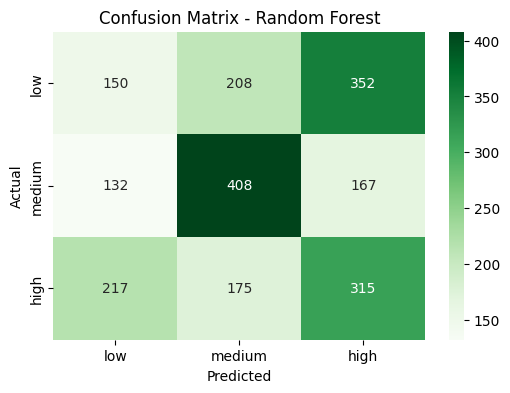

              precision    recall  f1-score   support

         low       0.30      0.21      0.25       710
      medium       0.52      0.58      0.54       707
        high       0.38      0.45      0.41       707

    accuracy                           0.41      2124
   macro avg       0.40      0.41      0.40      2124
weighted avg       0.40      0.41      0.40      2124

Train participant: [ 1  3  4  5  6  7  9 10 11 12 13 14]
Test participant: 2
low: 18839 medium: 18838 high: 18895
low: 1332 medium: 1332 high: 1336
Random Forest Accuracy: 0.35


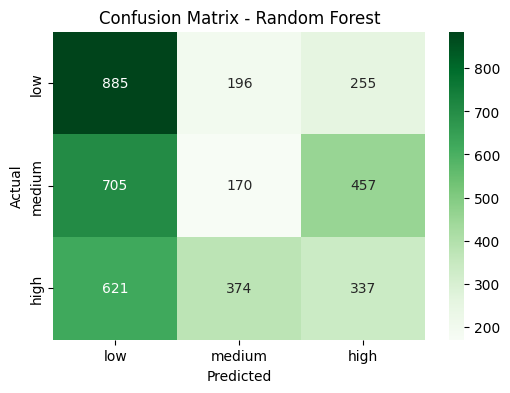

              precision    recall  f1-score   support

         low       0.40      0.66      0.50      1336
      medium       0.23      0.13      0.16      1332
        high       0.32      0.25      0.28      1332

    accuracy                           0.35      4000
   macro avg       0.32      0.35      0.32      4000
weighted avg       0.32      0.35      0.32      4000

Train participant: [ 1  2  4  5  6  7  9 10 11 12 13 14]
Test participant: 3
low: 18643 medium: 18642 high: 18699
low: 1528 medium: 1527 high: 1533
Random Forest Accuracy: 0.29


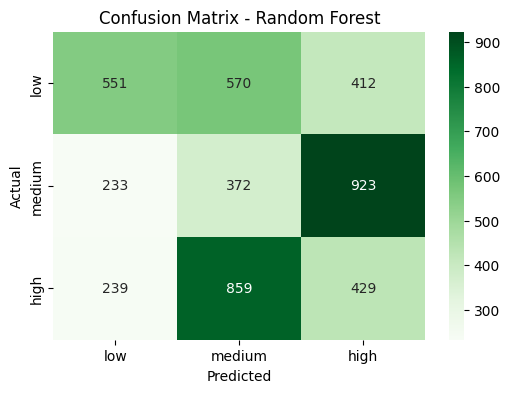

              precision    recall  f1-score   support

         low       0.54      0.36      0.43      1533
      medium       0.21      0.24      0.22      1528
        high       0.24      0.28      0.26      1527

    accuracy                           0.29      4588
   macro avg       0.33      0.29      0.31      4588
weighted avg       0.33      0.29      0.31      4588

Train participant: [ 1  2  3  5  6  7  9 10 11 12 13 14]
Test participant: 4
low: 18654 medium: 18654 high: 18711
low: 1516 medium: 1516 high: 1521
Random Forest Accuracy: 0.34


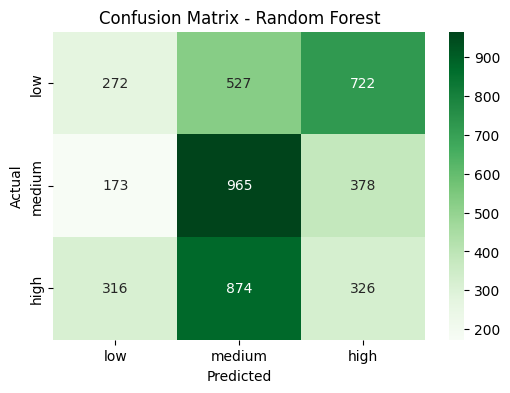

              precision    recall  f1-score   support

         low       0.36      0.18      0.24      1521
      medium       0.41      0.64      0.50      1516
        high       0.23      0.22      0.22      1516

    accuracy                           0.34      4553
   macro avg       0.33      0.34      0.32      4553
weighted avg       0.33      0.34      0.32      4553

Train participant: [ 1  2  3  4  6  7  9 10 11 12 13 14]
Test participant: 5
low: 18452 medium: 18452 high: 18507
low: 1719 medium: 1718 high: 1724
Random Forest Accuracy: 0.25


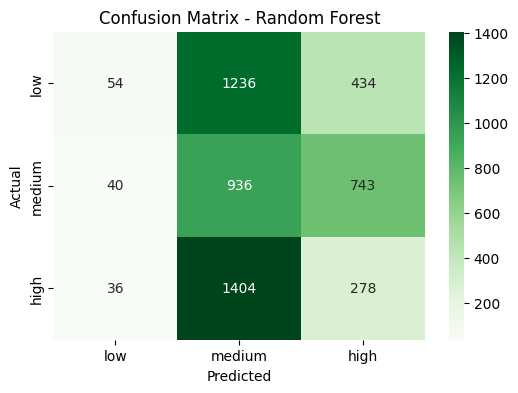

              precision    recall  f1-score   support

         low       0.42      0.03      0.06      1724
      medium       0.26      0.54      0.35      1719
        high       0.19      0.16      0.18      1718

    accuracy                           0.25      5161
   macro avg       0.29      0.25      0.20      5161
weighted avg       0.29      0.25      0.20      5161

Train participant: [ 1  2  3  4  5  7  9 10 11 12 13 14]
Test participant: 6
low: 18378 medium: 18378 high: 18433
low: 1793 medium: 1792 high: 1798
Random Forest Accuracy: 0.28


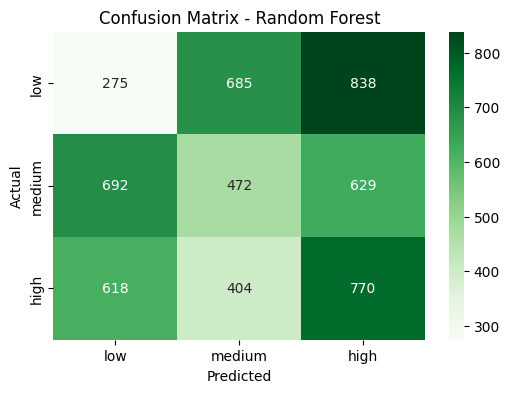

              precision    recall  f1-score   support

         low       0.17      0.15      0.16      1798
      medium       0.30      0.26      0.28      1793
        high       0.34      0.43      0.38      1792

    accuracy                           0.28      5383
   macro avg       0.27      0.28      0.28      5383
weighted avg       0.27      0.28      0.28      5383

Train participant: [ 1  2  3  4  5  6  9 10 11 12 13 14]
Test participant: 7
low: 18759 medium: 18759 high: 18816
low: 1411 medium: 1411 high: 1416
Random Forest Accuracy: 0.34


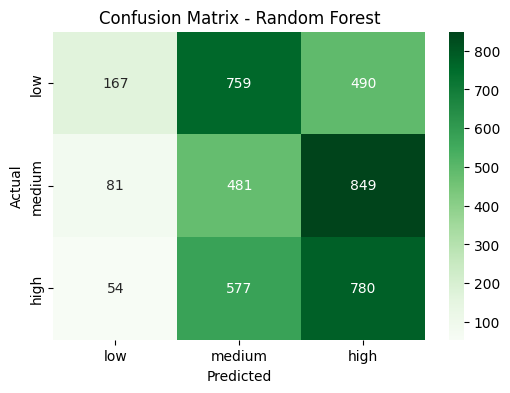

              precision    recall  f1-score   support

         low       0.55      0.12      0.19      1416
      medium       0.26      0.34      0.30      1411
        high       0.37      0.55      0.44      1411

    accuracy                           0.34      4238
   macro avg       0.40      0.34      0.31      4238
weighted avg       0.40      0.34      0.31      4238

Train participant: [ 1  2  3  4  5  6  7 10 11 12 13 14]
Test participant: 8
low: 18440 medium: 18440 high: 18496


/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IndexError: tuple index out of range

In [26]:
load_part_list = np.array([1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14])
for ps in range(1, len(load_part_list) + 1):
    new_arr = np.delete(load_part_list, ps - 1)
    print("Train participant:", new_arr)
    print("Test participant:", ps)

    X, y, p = load_data(new_arr, z_score_norm="participant_meanfree", print_info=False)
    X_train = X.reshape(X.shape[0], X.shape[1] * X.shape[1])
    _, y_train = classification(y)

    X_test, y_test, p_test = load_data(
        [ps], z_score_norm="participant_meanfree", print_info=False
    )
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[1])

    # test data of participant
    _, y_test = classification(y_test)

    # model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred_rf = rf_model.predict(X_test)

    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

    cm_rf = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm_rf,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=["low", "medium", "high"],
        yticklabels=["low", "medium", "high"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - Random Forest")
    plt.show()

    print(
        classification_report(y_test, y_pred_rf, target_names=["low", "medium", "high"])
    )